In [21]:
import gymnasium
import highway_env

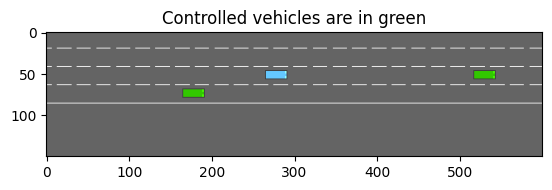

In [22]:
env = gymnasium.make(
  "highway-v0",
  render_mode="rgb_array",
  config={
    "controlled_vehicles": 2,  # Two controlled vehicles
    "vehicles_count": 1,       # A single other vehicle, for the sake of visualisation
  }
)
env.reset(seed=0)

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(env.render())
plt.title("Controlled vehicles are in green")
plt.show()

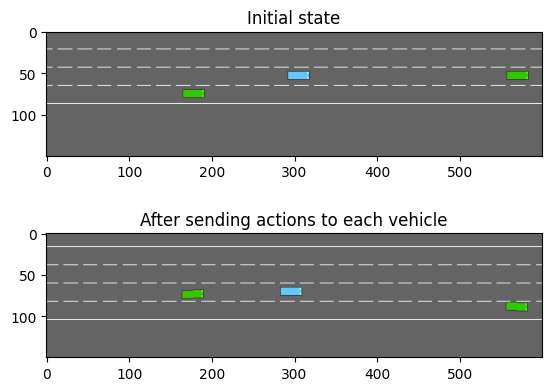

In [23]:
# Create environment with render_mode specified
# env = gymnasium.make('highway-v0', render_mode="rgb_array")

env.unwrapped.config.update({
  "action": {
    "type": "MultiAgentAction",
    "action_config": {
      "type": "DiscreteMetaAction",
    }
  }
})
env.reset()

_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.imshow(env.render())
ax1.set_title("Initial state")

# Make the first vehicle change to the left lane, and the second one to the right
action_1, action_2 = 0, 2  # See highway_env.envs.common.action.DiscreteMetaAction.ACTIONS_ALL
env.step((action_1, action_2))

ax2.imshow(env.render())
ax2.set_title("After sending actions to each vehicle")
plt.show()

In [27]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [73]:
import gymnasium
import numpy as np
from stable_baselines3 import DQN
import time

# 1. Create environment with render mode
env = gymnasium.make('highway-v0', render_mode="rgb_array")

# 2. Basic environment configuration
env.unwrapped.configure({
    "controlled_vehicles": 2,      # Number of vehicles controlled
    "vehicles_count": 5,           # Total vehicles in the env
    "show_trajectories": True,     # Visualize trajectories
    "initial_lane_id": 1,         # Starting lane
    "screen_width": 600,          # For better visualization
    "screen_height": 400,
    "simulation_frequency": 10,    # FPS
    "policy_frequency": 5,
    # Set initial positions for the two vehicles
    "initial_positions": [
        [0, 0],    # First vehicle: [longitudinal, lateral]
        [10, 1]    # Second vehicle: different lane and distance
    ]
})

# 3. Multi-agent configuration
env.unwrapped.config.update({
    "controlled_vehicles": 2,
    "observation": {
        "type": "MultiAgentObservation",
        "observation_config": {
            "type": "Kinematics",
        }
    },
    "action": {
        "type": "MultiAgentAction",
        "action_config": {
            "type": "DiscreteMetaAction",
        }
    }
})

# 4. Load your trained models
model_ego = DQN.load("highway_dqn/model_ego",device='cpu')
model_bh_drive = DQN.load("highway_dqn/model_aggressive",device='cpu')

# Create list of models in order of vehicle control
models = [model_ego, model_bh_drive]

# 5. Run the simulation
obs, info = env.reset()

# Verify we have two vehicles
print(f"Number of vehicles being observed: {len(obs)}")
print(f"Observation shapes: {[o.shape for o in obs]}")

done = truncated = False
while not (done or truncated):
    # Get actions from each model
    action = tuple(model.predict(obs_i, deterministic=True)[0] 
                  for model, obs_i in zip(models, obs))
    
    # Execute actions
    next_obs, reward, done, truncated, info = env.step(action)
    
    # Render
    env.render()
    
    # Optional: add delay to better visualize
    time.sleep(0.1)  # Adjust this value to change visualization speed
    
    obs = next_obs

# Wait 3 seconds before closing
time.sleep(3)
env.close()

Number of vehicles being observed: 2
Observation shapes: [(5, 5), (5, 5)]


AttributeError: 'NoneType' object has no attribute 'get_image'